In [1]:
# The prompt will be used for text normalization

prompt = """
You are a text processing assistant tasked with normalizing raw composition writer information. The goal is to remove redundant information (such as publishing company names or copyright markers) and retain only the names of the writers, formatted properly.

Here are the rules you should follow:
1. Extract Writer Names: Identify and retain only the names of the writers.
2. Remove Redundancies: Exclude terms such as "Copyright Control," publishing company names, or any other non-writer-related entities.
3. Format Names: Ensure that names are properly formatted as "First Last" or "First Middle Last" where applicable. Preserve capitalization and fix cases where necessary.
4. Preserve Structure: Keep writer names separated by `/` if there are multiple writers.
5. Keep the letter case intact
6. Do not explain your answer. Just provide the names.


Examples for Reference:
1. RAW TEXT: Jordan Riley/Adam Argyle/Martin Brammer
   NORMALIZED TEXT: Jordan Riley/Adam Argyle/Martin Brammer

2. RAW TEXT: Chip Whitesides, Jason Beam, James Ford, Brad Sellers & Kelly Wallace
   NORMALIZED TEXT: Chip Whitesides/Jason Beam/James Ford/Brad Sellers/Kelly Wallace

3. RAW TEXT: <Unknown>/Wright, Justyce Kaseem
   NORMALIZED TEXT: Justyce Kaseem Wright

4. RAW TEXT: Pixouu/Abdou Gambetta/Copyright Control
   NORMALIZED TEXT: Pixouu/Abdou Gambetta

Task: Given the following raw text, perform the normalization as described above:
[INPUT RAW TEXT]: {input_raw_text}
"""


In [2]:
def clean_text(text: str) -> str:
  """Remove specific symbols and replace them with '/'

  Arguments:
    text: the input text

  Returns:
    the cleaned text  

  """
  text = text.replace('\n', '/').strip()
  text = text.replace('&', '/').strip()
  text = text.replace(' / ', '/').strip()
  text = text.replace('//', '/').strip()
  return text

In [3]:
import ollama

def generate_normalized_text(input_text: str) -> str:
    """Generates the normalized text using Llama3.1

    Arguments:
        input_text: the input text

    Returns:
        the normalized text    
    """
    try:
        final_prompt = prompt.format(input_raw_text=input_text)
        response = ollama.chat(
        model="llama3.1",
        messages=[
            {
                "role": "user",
                "content": final_prompt,
            },
        ],
        # options={"temperature":0.0}
    )
        print("INPUT TEXT:", input_text)
    except:
        return "no text"    
    return response["message"]["content"]

In [4]:
import pandas as pd

data_path = 'normalization_assesment_dataset_10k.csv'
df = pd.read_csv(data_path)
df.head()

,raw_comp_writers_text,CLEAN_TEXT
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN
4,Alvin Lee,Alvin Lee


In [5]:
df = df.dropna(subset=['CLEAN_TEXT'])

In [6]:
# For our experiments we will use 3000 utterances for time saving
df =df[:3000]

In [7]:
raw_texts = df['raw_comp_writers_text']
cleaned_texts = df['CLEAN_TEXT']

In [8]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_patterns(df: pd.DataFrame):
    """Plots bar plots with the most common terms appearing in the whole raw texts

    df: the input dataframe
    """
    text = ' '.join(df['raw_comp_writers_text'])
    splitted_text = text.split('/')
    term_counts = Counter(splitted_text)
    most_common_terms = term_counts.most_common(40)
    terms, counts = zip(*most_common_terms)

    plt.figure(figsize=(16, 16))
    
    ax = sns.barplot(x=terms, y=counts, palette='pastel')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
    ax.set_yticklabels(ax.get_yticks(), fontsize=14)
    
    plt.title('Top 40 Terms', fontsize=15)
    plt.xlabel('Terms', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.show()

C:\Users\Aggelos\AppData\Local\Temp\ipykernel_8068\3708161502.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=terms, y=counts, palette='pastel')
C:\Users\Aggelos\AppData\Local\Temp\ipykernel_8068\3708161502.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=14)
C:\Users\Aggelos\AppData\Local\Temp\ipykernel_8068\3708161502.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=14)


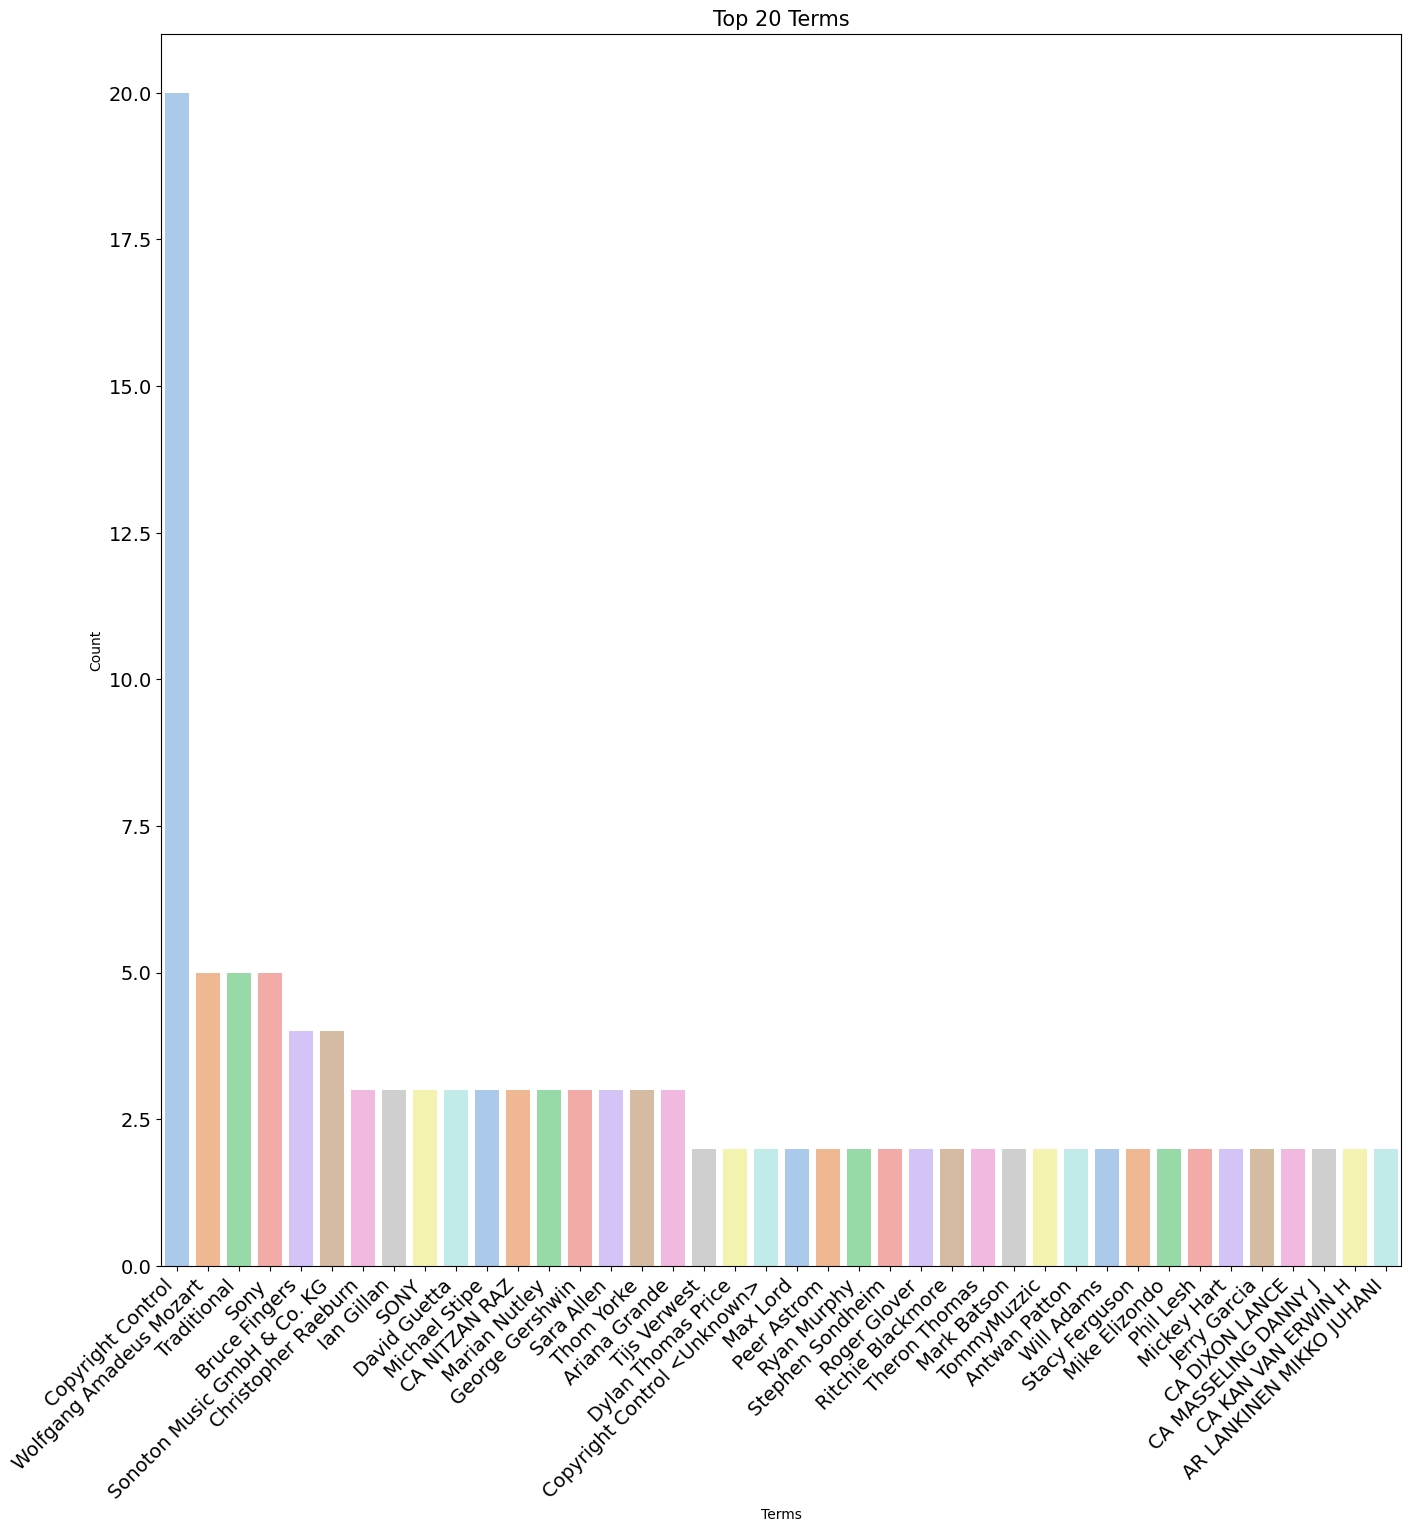

In [ ]:
plot_patterns(df)

In [9]:
def remove_keywords(raw_text: str) -> str:
    """Remove certain keywords from the raw text
    
    Arguments:
        raw_text: the input text

    Returns:
        the cleaned text without the keywords 
    """
    keywords_to_remove = {
        "Copyright Control",
        "Traditional",
        "Sonoton Music GmbH & Co. KG",
        "<Unknown>",
        "SONY",
        "Sony"
    }
    cleaned_text = raw_text
    for term in keywords_to_remove:
        cleaned_text = cleaned_text.replace(term, "")
    return cleaned_text.strip()



In [ ]:
normalized_texts = []

for raw_text in raw_texts:
    normalized_text = generate_normalized_text(raw_text)
    normalized_texts.append(normalized_text)

In [9]:
df['normalized_text'] = normalized_texts

In [10]:
df.to_csv('output.csv', index=False)

In [7]:
# Read directly the output.csv
df = pd.read_csv('output.csv')

In [12]:
df['normalized_text'] = df['normalized_text'].apply(remove_keywords)
df['normalized_text'] = df['normalized_text'].apply(clean_text)

In [13]:
import Levenshtein

def levenshtein_distance(s1: str, s2: str) -> float:
    """Calculates the levenshtein similarity between two strings

    Arguments:
        s1: the first input string
        s2: the second input string

    Returns:
        the levenshtein similarity score 
    """
    return Levenshtein.distance(s1, s2)

In [14]:
df

,raw_comp_writers_text,CLEAN_TEXT,normalized_text
0,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer,Jordan Riley/Adam Argyle/Martin Brammer
1,Martin Hygård,Martin Hygård,Martin Hygard
2,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...,Jesse Robinson/Greg Phillips/Kishaun Bailey/Ka...
3,Mendel Brikman,NaN,Mendel Brikman
4,Alvin Lee,Alvin Lee,Alvin Lee
...,...,...,...
2995,Fredericka Seay,Fredericka Seay,Fredericka Seay
2996,G. Abbott/Bruce Dickinson,G. Abbott/Bruce Dickinson,G. Abbott/Bruce Dickinson
2997,Carmelo La Bionda/Johnson Righeira,NaN,Carmelo La Bionda/Johnson Righeira
2998,Wascar Feliz,Wascar Feliz,Wascar Feliz


In [20]:
# Calculate the Levenshtein distance for each pair and compute the average score
df['levenshtein_distance'] = df.apply(lambda row: levenshtein_distance(row['normalized_text'], row['CLEAN_TEXT']), axis=1)
avg_levenshtein_distance = sum(df['levenshtein_distance']) / len(df)
print(avg_levenshtein_distance)

C:\Users\Aggelos\AppData\Local\Temp\ipykernel_17084\2559914381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['levenshtein_distance'] = df.apply(lambda row: levenshtein_distance(row['normalized_text'], row['CLEAN_TEXT']), axis=1)


In [25]:
# Calculate the accuracy of the exact mathes
df['match'] = df['CLEAN_TEXT'] == df['normalized_text']
accuracy = df['match'].mean() * 100
print(accuracy)

84.0
